# Dataset ISAC-CNR
Registrazione delle misure recuperate dal database ISAC fornito da Michele Brunetti.

La procedura si articola nei seguenti passaggi:
1. [caricamento dei dati grezzi](#caricamento-da-frammenti) e uniformazione negli schemi esposti sotto;
1. [primo quality check](#quality-check): controllo errori di consistenza nella singola serie e nelle coppie di serie della stessa stazione;
1. [overview disponibilità dati](#overview-disponibilità-dati): plot che mostrano la disponibilità temporale e spaziale di serie;
1. [merging](#merging) del dataset con SCIA.

## Data model
### Metadati
| station_id | station_name | network | state | lon    | lat    | elevation | dataset_id | original_id |
|------------|--------------|---------|-------|--------|--------|-----------|------------|-------------|
| utf8()     | utf8()       | utf8()  | utf8()|double()|double()| double()  | utf8()     | utf8()      |
| pkey       | obs          | obs     | obs   | obs    | obs    | obs       | fkey       | obs         |

I metadati delle stazioni che non rientrano nelle tabelle elencate vanno in una tabella "extra" collegata tramite "station_id".

### Dati
|series_id|date|value|merged|variable|
|---------|----|-----|------|--------|
|utf8()|date()|double()|bool()|utf8()|
| fkey    |obs | obs | obs  | obs    |

Note:
- `merged` indica se il valore in riga è il risultato di un merge.


In [1]:
dataset_id <- "ISAC"
state <- "Italia"


In [2]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)
library(zeallot, warn.conflicts = FALSE)
library(stringr, warn.conflicts = FALSE)
options(repr.plot.width = 9, repr.plot.res = 300)


source(str_glue("notebooks/integrazioni_nazionali/ISAC/procedures/load_daily.R"))
source("notebooks/integrazioni_regionali/procedure/common_steps.R")
source("notebooks/integrazioni_regionali/procedure/checkpoint.R")
source("src/database/tools.R")
source("src/load/ITA.R")

first_date <- as.Date("2000-01-01")
last_date <- as.Date("2022-12-31")
ita_bbox <- st_bbox(c(xmin = 6.5, xmax = 14.5, ymax = 47.5, ymin = 42), crs = st_crs(4326)) |> st_as_sfc()
ita_boundaries <- load.italian_boundaries("state")


Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



## Caricamento da frammenti
Dati giornalieri come forniti dall'ente, in formato tabella Arrow


In [3]:
daily_dataset <- load_daily_data.isac() |> prepare_daily_data(first_date, last_date)
checkpoint_database(daily_dataset$database, dataset_id, "raw")
write_extra_metadata(daily_dataset$extra_meta, dataset_id, provisional = FALSE)
rm(daily_dataset)
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,1710403,91.4,5369857,286.8,NA,5369857,286.8
Vcells,58180199,443.9,680982642,5195.5,16384,790507166,6031.1


## Quality check 1
Controllo gross errors, dati ripetuti, T_MIN >= T_MAX, serie intere

In [4]:
raw_database <- open_checkpoint(dataset_id, "raw")
# Loses many rows in na values
qc_database <- qc1(raw_database, stop_on_error = FALSE)

checkpoint_database(qc_database, dataset_id, "qc1")
rm(raw_database)
rm(qc_database)
gc()


Warning message:
"The resulting dataset has an unusually small number of elements wrt to the original"


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,1932579,103.3,5369857,286.8,NA,5369857,286.8
Vcells,26735437,204.0,366871985,2799.1,16384,790507166,6031.1


## Analisi disponibilità dati
Grafici che mostrano la disponibilità di serie mese per mese e sul territorio

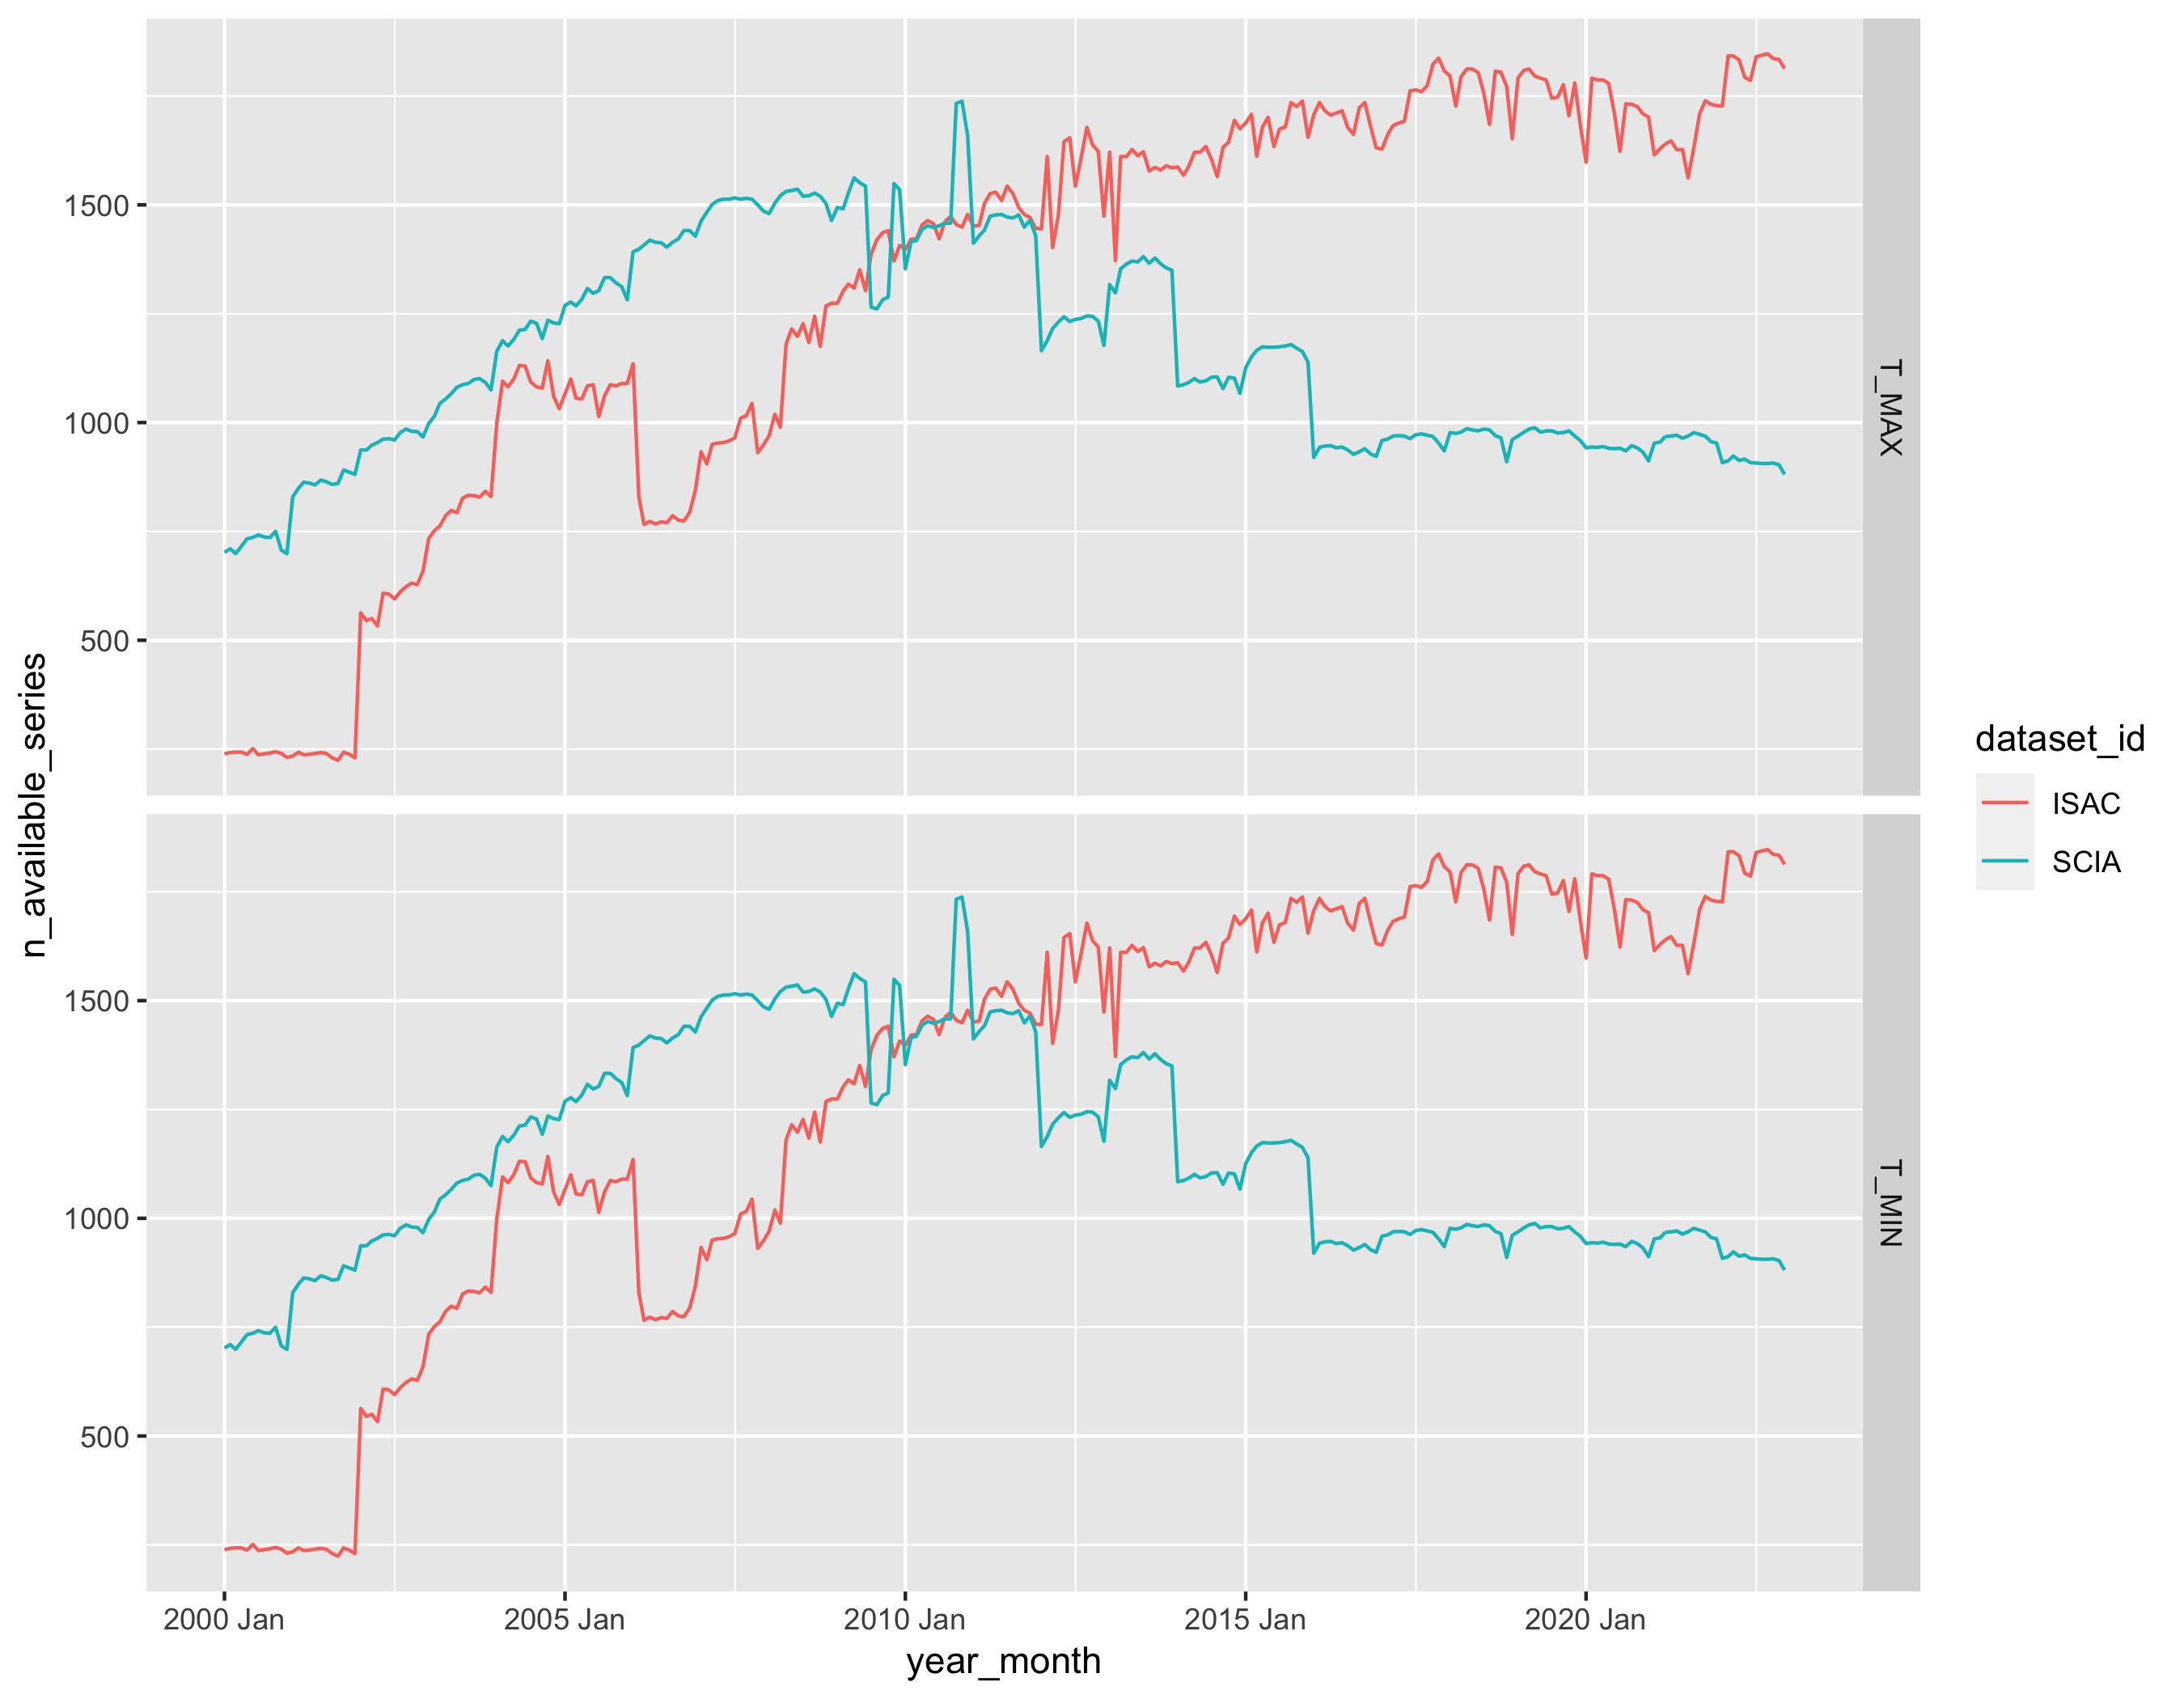

In [5]:
qc_database <- open_checkpoint(dataset_id, "qc1")
qc_scia <- open_checkpoint("SCIA", "qc1") |> filter_checkpoint_inside(ita_bbox)
c(p, ymonthly_avail) %<-% ymonthly_availabilities(qc_database, against = qc_scia, region = ita_bbox, start_date = first_date, end_date = last_date)
p


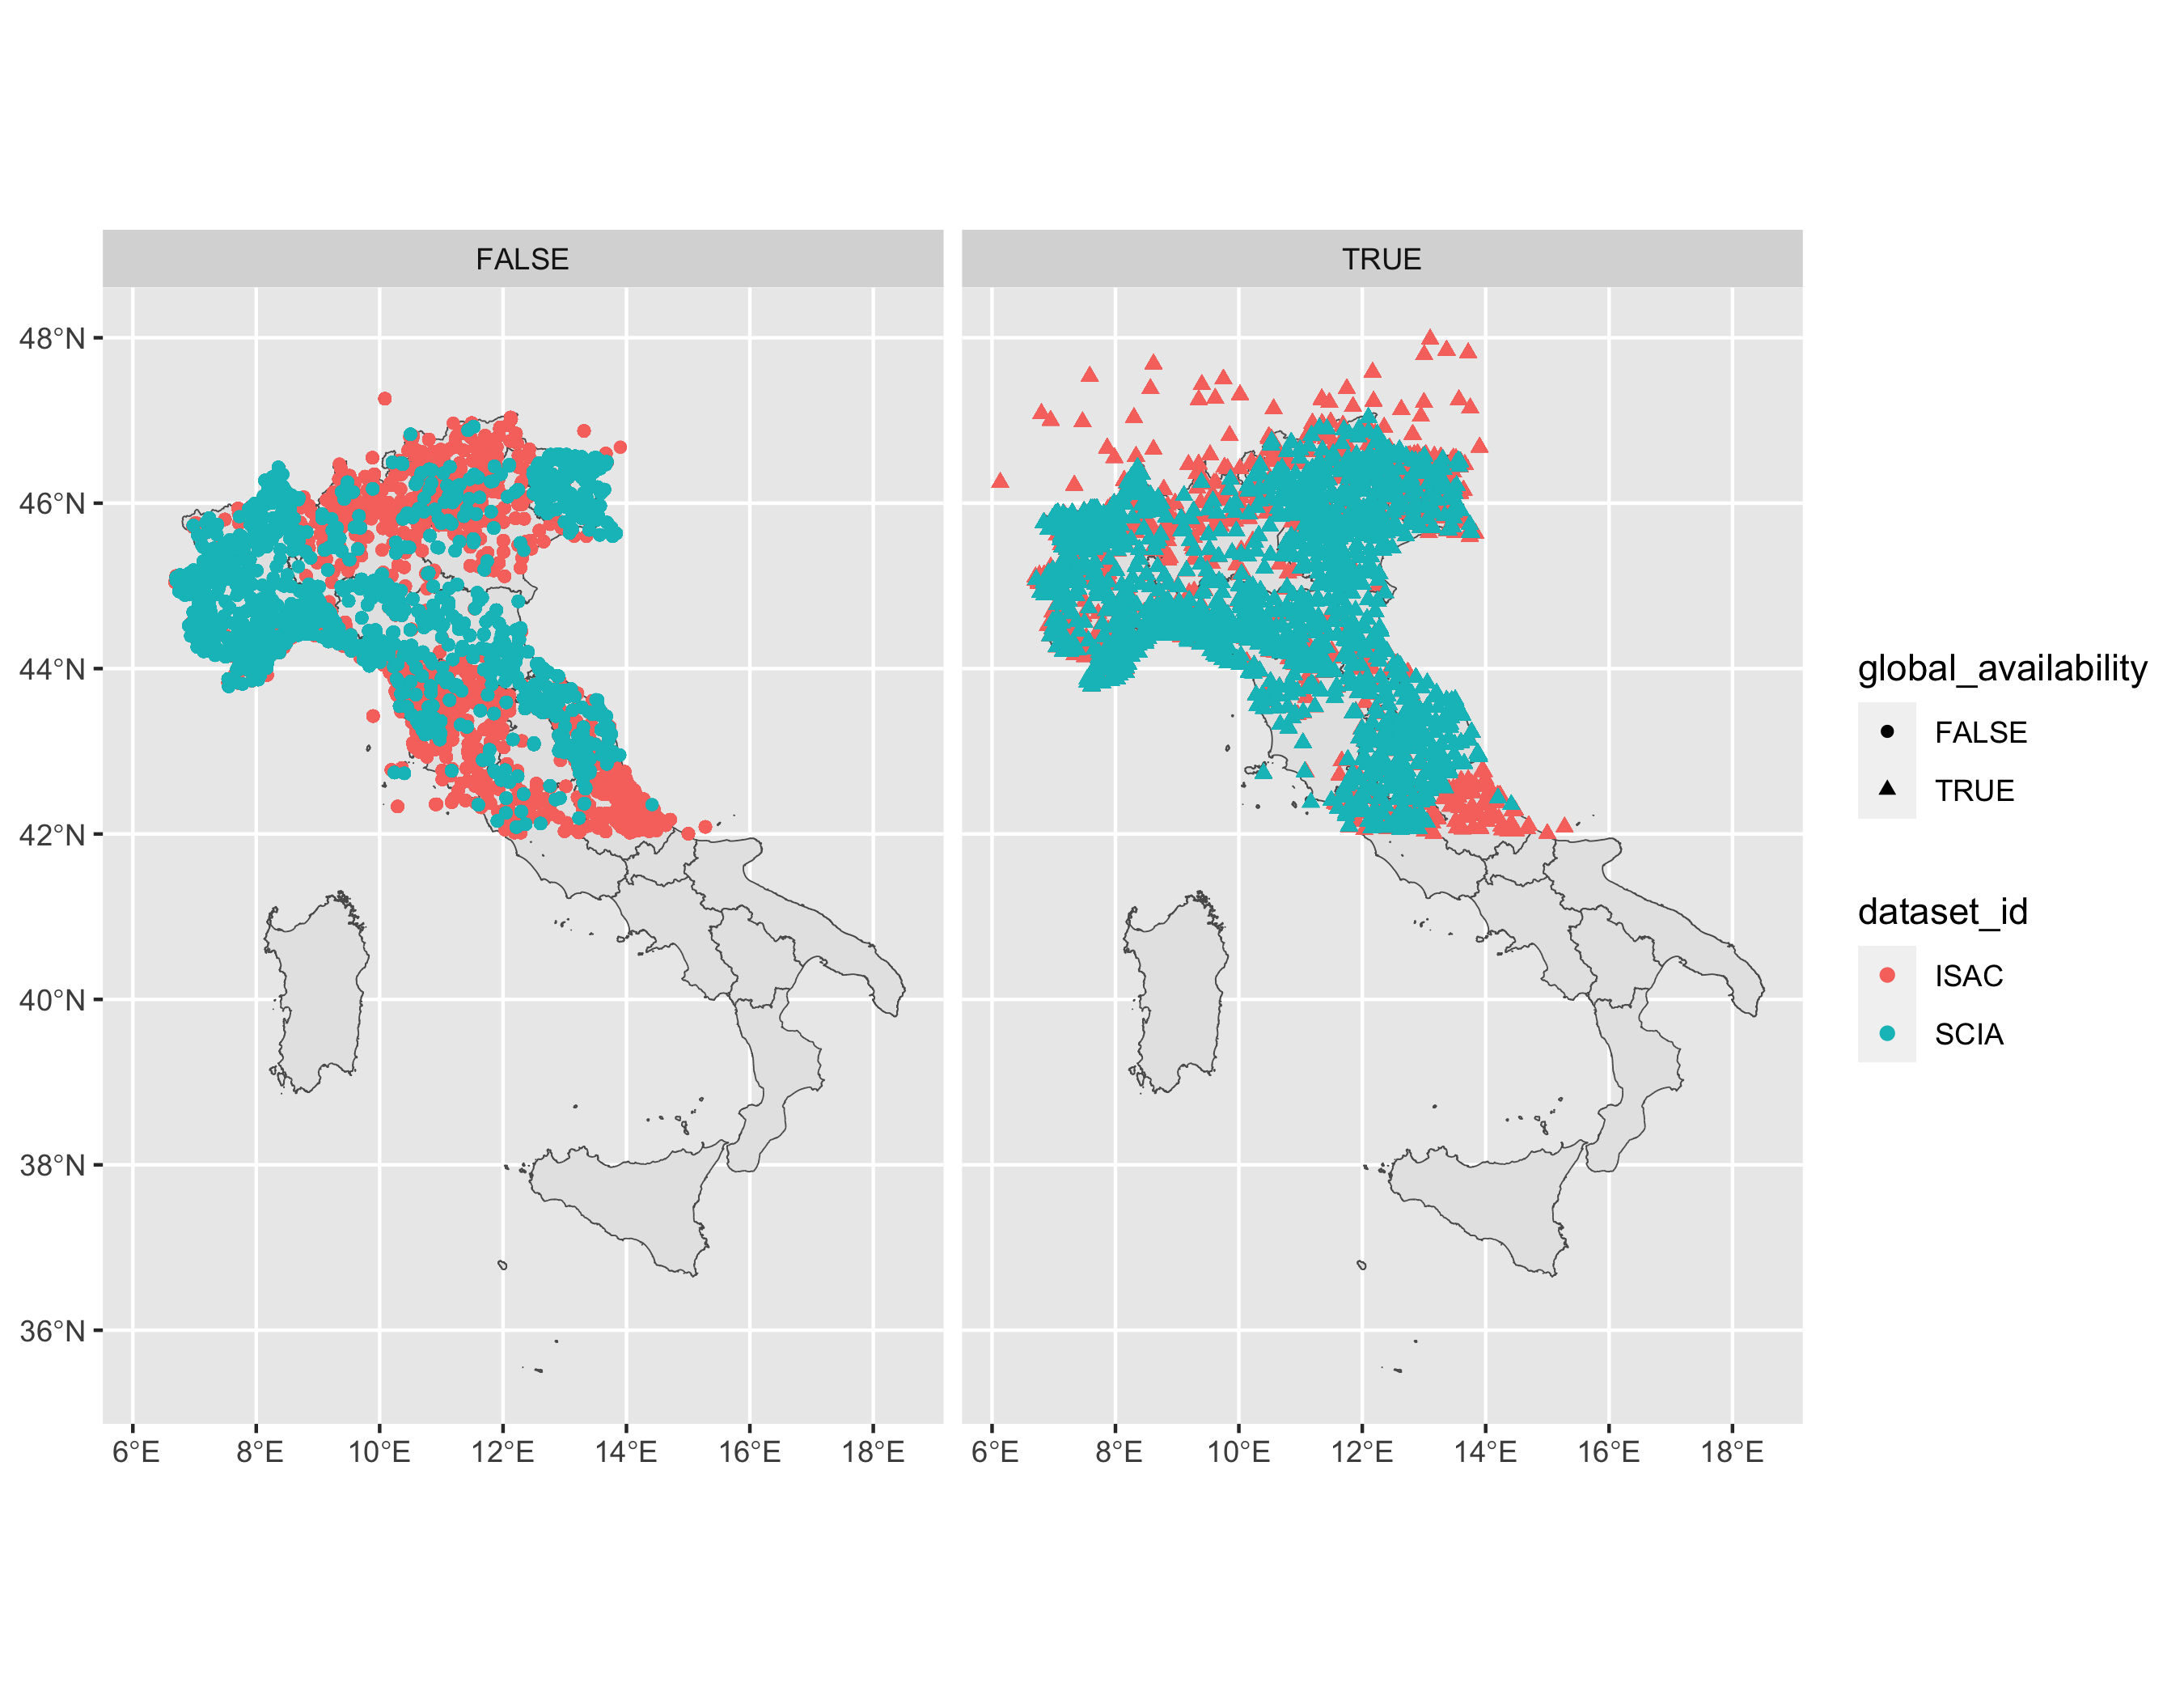

In [8]:
c(p, climats) %<-% spatial_availabilities(ymonthly_avail, concat_tables(qc_database$meta, qc_scia$meta, unify_schemas = FALSE), ita_boundaries)
p + facet_grid(~ global_availability)


## Merging
Gap-filling con altri dataset.
Registrazione dell'esito.

In [7]:
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2462159,131.5,14552568,777.2,NA,18190710,971.5
Vcells,20456287,156.1,1638485436,12500.7,16384,2048106794,15625.9
